### MODEL 2 : Building a Convolutional Neural Network (CNN)
CNN's are also known as ConvNets.

They are known for their ability to find patterns in visual data

In [8]:
import torch 
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt 
import tqdm

device="cuda" if torch.cuda.is_available() else "cpu"

print(torch.__version__)
print(torchvision.__version__)

2.0.0
0.15.0


In [9]:
train_data=datasets.FashionMNIST(
    root="data", #where to download data to
    train=True,
    download=True,
    transform=ToTensor(), #How do we want to transform the data ?
    target_transform=None  #How do we want to transform the labels/targets ?
)

test_data=datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)
len(train_data),len(test_data)

(60000, 10000)

In [10]:
image,label=train_data[0]
class_names=train_data.classes
class_to_idx = train_data.class_to_idx


In [11]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

#Turn datasets into iterables ( batches )
train_dataloader=DataLoader(dataset=train_data,
                            batch_size=BATCH_SIZE,
                            shuffle=True)
test_dataloader=DataLoader(dataset=test_data,
                           batch_size=BATCH_SIZE,
                           shuffle=False)

train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x2121a891520>,
 <torch.utils.data.dataloader.DataLoader at 0x2121a8a2d60>)

In [12]:
def eval_model(model:torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               accuracy_fn):
    """ Returns a dictionary containing the results of model predicting on data_loader"""
    loss,acc=0,0
    model.eval()
    with torch.inference_mode():
        for X,y in tqdm(data_loader):
            
            #make preds
            y_pred=model(X)

            #Accumulate the loss and acc values per batch
            loss += loss_fn(y_pred,y)
            acc += accuracy_fn(y_true=y,
                               y_pred=y_pred.argmax(dim=1))
        # Scale loss and acc to find the avarage loss/ acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__,#only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

In [13]:
from helper_functions import accuracy_fn
def train_step(model:torch.nn.Module,
               data_loader:torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device:torch.device=device):
    """Performs a training with model trying to learn on data_loader."""
    train_loss,train_acc=0,0
    
    #Put model into training mode
    model.train()

    # Add a loop to loop through training batches X-> image, y->label(target)
    for batch , (X,y) in enumerate(data_loader):
        
        #Put data on target device
        X,y=X.to(device),y.to(device)
        
        #1. Forward pass (outputs the raw logits from the model)
        y_pred=model(X)

        #2. Calculate the loss
        loss=loss_fn(y_pred,y)
        train_loss +=loss #accumulate train loss
        train_acc+=accuracy_fn(y_true=y,
                               y_pred=y_pred.argmax(dim=1)) #go from logits->prediction labels
        
        #3. Optimizer zero grad
        optimizer.zero_grad()

        #4. Loss backward
        loss.backward()

        #5. Optimizer
        optimizer.step() 

    train_loss/=len(data_loader)
    train_acc/=len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

In [14]:
def test_step(model:torch.nn.Module,
              data_loader:torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module,
              accuracy_fn,
              device:torch.device=device):
    """Performs a testing loop step on model going over data_loader."""
    test_loss,test_acc=0,0

    #Put model into eval mode
    model.eval()

    with torch.inference_mode():
        for X,y in data_loader:
            #Data into device
            X,y=X.to(device),y.to(device)
            
            #1. Forward pass
            test_pred=model(X)

            #2. Calculate loss and acc(accumulatively)
            test_loss+=loss_fn(test_pred,y)
            test_acc+=accuracy_fn(y_true=y,
                                  y_pred=test_pred.argmax(dim=1))
            
        # Calculate the test loss/acc average per patch
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc {test_acc:.4f}")

Image size: torch.Size([1, 28, 28])
Label: 7, label size: torch.Size([])


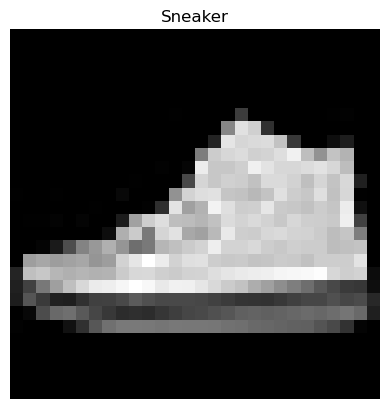

In [20]:
train_features_batch,train_labels_batch=next(iter(train_dataloader))
train_features_batch.shape,train_labels_batch.shape
random_idx=torch.randint(0,len(train_features_batch),size=[1]).item()
img,label=train_features_batch[random_idx],train_labels_batch[random_idx]
plt.imshow(img.squeeze(),cmap="gray")
plt.title(class_names[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

In [21]:
torch.manual_seed(42)

class FashionMNISTModelV2(nn.Module):
    """
    Model architecture that replicates TinyVGG
    model from CNN explainer site.
    
    """
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.conv_block_1=nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1), #hyperparameters of Conv2d
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)#kernel size can also be a tuple such as (2,2)

        )
        self.conv_block_2=nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier_layer=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*0,
                      out_features=output_shape)#out features -> class_names
        )

    def forward(self,x:torch.tensor):
        x=self.conv_block_1(x)
        print(x.shape)
        x=self.conv_block_2(x)
        print(x.shape)
        x=self.classifier_layer(x)
        return x

In [24]:
torch.manual_seed(42)
#input shape is 1 beacuse we have 1 color channel
model_2=FashionMNISTModelV2(input_shape=1,
                            hidden_units=10,
                            output_shape=len(class_names)).to(device)

c:\Users\TRON PCH\miniconda3\envs\ai_env2\lib\site-packages\torch\nn\init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


torch.Size([1, 28, 28])